In [1]:
#IMPORTING PACKAGAES######

from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

In [49]:
##READING IN DATA#####
#Reformatting data into a timeseries via converting string values to datetime values ####
#indexing that dataset with the time column#####

path = pd.read_csv(r"C:\Users\Vinnie\OneDrive\Desktop\owid-covid-data_wrangled_timeseries.csv")
path.dropna()
path['date'] = pd.to_datetime(path['date'],infer_datetime_format=True)
indexedDataset = path.set_index(['date'])
indexedDataset.head(5)

,total_deaths,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand
date,,,,
2020-07-20,1087,278.364,6.73,1.9
2020-07-21,1100,278.364,6.73,1.9
2020-07-22,1111,278.364,6.73,1.9
2020-07-23,1124,278.364,6.73,1.9
2020-07-25,1146,278.364,6.73,1.9


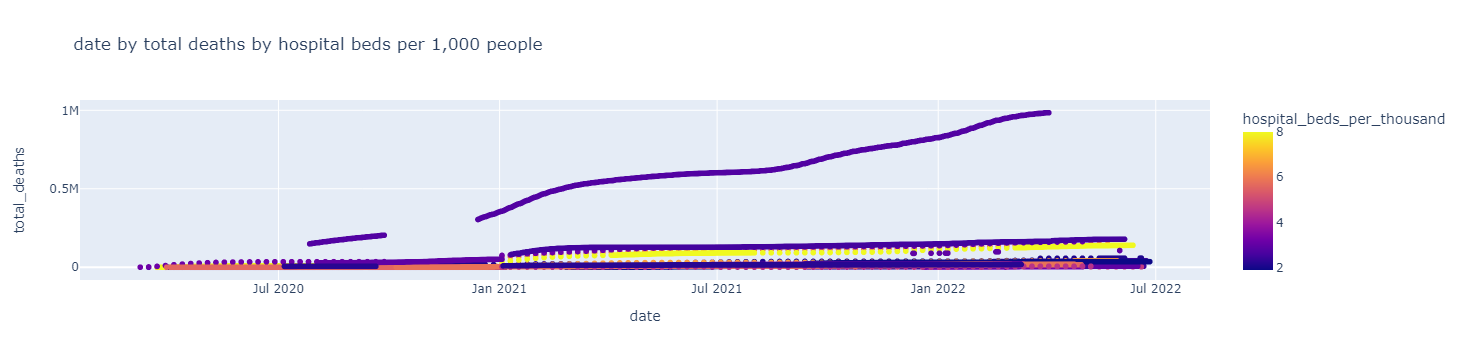

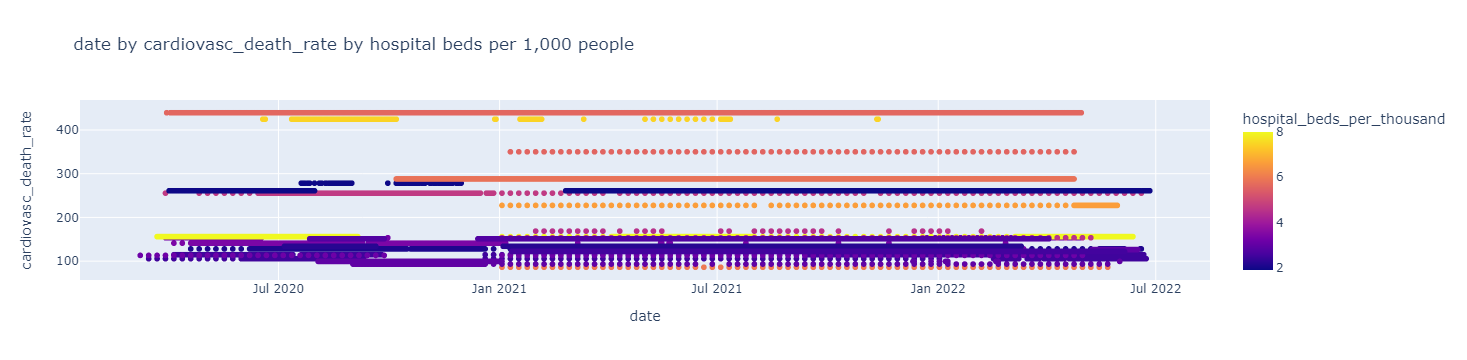

In [52]:
#PLOTTING New cases and New deaths overtime for visual refernce of distribution in a timeseries and setting pixelation dimensionality to 12 length units by 6 width units#####

fig = px.scatter(path, x='date', y='total_deaths', color='hospital_beds_per_thousand', title='date by total deaths by hospital beds per 1,000 people')
(figsize:=(12,6))
fig.show()
                 
fig = px.scatter(path, x='date', y='cardiovasc_death_rate', color='hospital_beds_per_thousand', title='date by cardiovasc_death_rate by hospital beds per 1,000 people')
(figsize:=(12,6))
fig.show()

In [53]:
###Using numpy functions to calculate rolling mean and rolling standard deviation with a window of 21 hours then print#####
rolmean = indexedDataset.rolling(window=7).mean()
rolstd = indexedDataset.rolling(window=7).std()
print(rolmean,rolstd)

             total_deaths  cardiovasc_death_rate  diabetes_prevalence  \
date                                                                    
2020-07-20            NaN                    NaN                  NaN   
2020-07-21            NaN                    NaN                  NaN   
2020-07-22            NaN                    NaN                  NaN   
2020-07-23            NaN                    NaN                  NaN   
2020-07-25            NaN                    NaN                  NaN   
...                   ...                    ...                  ...   
2022-03-30  980487.714286                151.089                10.79   
2022-03-31  981130.142857                151.089                10.79   
2022-04-01  981799.000000                151.089                10.79   
2022-04-02  982468.000000                151.089                10.79   
2022-04-03  983133.857143                151.089                10.79   

            hospital_beds_per_thousand  
date     

In [54]:
##First ADF statistical code format using Deaths (our variable we want to predict)####

def ad_test(path):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adfuller(path['hospital_beds_per_thousand'])

(-3.5792024637846924,
 0.0061713085798831,
 0,
 7073,
 {'1%': -3.4312748798018067,
  '5%': -2.8619487232312757,
  '10%': -2.566987559330421},
 -6445.275239186363)

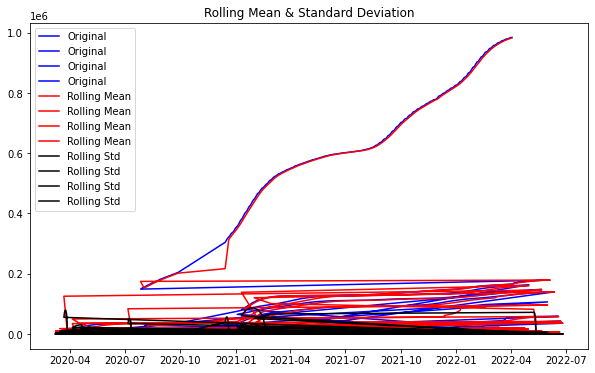

In [55]:
###Plotting mean and standard deviation of indexed dataset###
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [56]:
###Second Augmented Dickie format to check validity of first result####
##TEST STATISTIC IS EQUIVALENT TO FIRST TEST###
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['hospital_beds_per_thousand'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.579202
p-value                           0.006171
#Lags Used                        0.000000
Number of Observations Used    7073.000000
Critical Value (1%)              -3.431275
Critical Value (5%)              -2.861949
Critical Value (10%)             -2.566988
dtype: float64


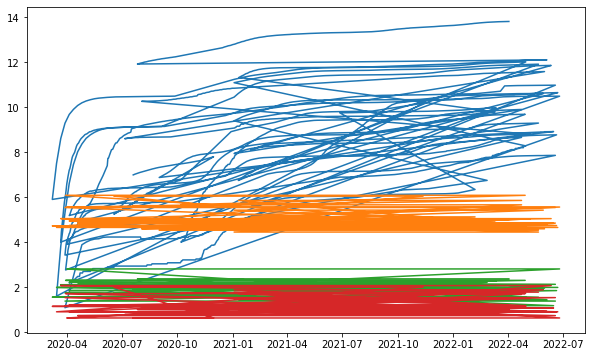

In [57]:
###LOGARITHMICALLY SCALING THE DATASET TO CHECK FOR STATIONARITY in visuals#####

indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

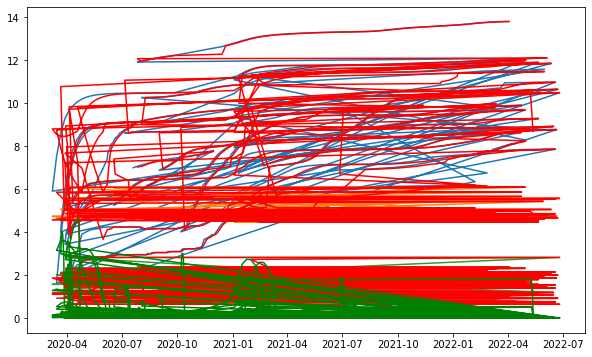

In [58]:
####DEVELOPING A STATIONARITY SERIES IN LOGARITHMIC FORM###
movingAverage = indexedDataset_logScale.rolling(window=7).mean()
movingSTD = indexedDataset_logScale.rolling(window=7).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.plot(movingSTD, color='green')

In [59]:
###STEPWISE FITTING THE ARIMA MODEL FOR New Deaths ###

from pmdarima import auto_arima
stepwise_fit = auto_arima(path['hospital_beds_per_thousand'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6491.558, Time=3.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6499.558, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6497.558, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6497.558, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6501.553, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6495.558, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 6.161 seconds


In [60]:
##DEFINING THE TRAIN AND TEST FEATURES OF ARIMA TO 21 HOURS WINDOW DURATION
print(path.shape)
train=path.iloc[:-7]
test=path.iloc[-7:]
print(train.shape,test.shape)

(7074, 5)
(7067, 5) (7, 5)


In [62]:
####MODEL SUMMARY OF COVID ARIMA MODEL###
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['hospital_beds_per_thousand'], order = (1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     hospital_beds_per_thousand   No. Observations:                 7067
Model:                         ARIMA(1, 0, 5)   Log Likelihood                3249.433
Date:                        Wed, 29 Jun 2022   AIC                          -6482.867
Time:                                23:18:26   BIC                          -6427.961
Sample:                                     0   HQIC                         -6463.956
                                       - 7067                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8257      0.693      5.524      0.000       2.468       5.183
ar.L1          0.9964      0.004    223.241      0.000       0.988       1.005
ma.L1          0.0018      0.455      0.004      0.997      -0.890       0.894
ma.L2          0.0018      0.455      0.004      0.997      -0.891       0.894
ma.L3          0.0018      0.456      0.004      0.997      -0.891       0.895
ma.L4          0.0018      0.456      0.004      0.997      -0.892       0.895
ma.L5          0.0018      0.456      0.004      0.997      -0.892       0.896
sigma2         0.0233    6.2e-05    375.934      0.000       0.023       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         174054008.00
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -3.59
Prob(H) (two-sided):                  0.00   Kurtosis:                       771.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

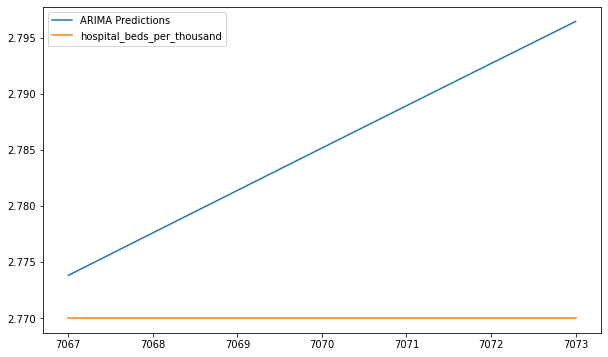

In [64]:
###Plotting ARIMA prediction###
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,type='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['hospital_beds_per_thousand'].plot(legend=True)

In [66]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['hospital_beds_per_thousand'].mean()
rmse=sqrt(mean_squared_error(pred,test['hospital_beds_per_thousand']))
print(rmse)

0.016923286005848925
